In [1]:
from fastai.tabular import *
import pandas as pd
import numpy as np
from fastai.metrics import accuracy

In [45]:
trn_df = pd.read_csv('train.csv',index_col='ID_code')
tst_df = pd.read_csv('test.csv',index_col='ID_code')

In [49]:
trn_df.head(2)

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,0,8.9255,-6.7863,11.9081,5.093,11.4607,-9.2834,5.1187,18.6266,-4.9200,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,0,11.5006,-4.1473,13.8588,5.389,12.3622,7.0433,5.6208,16.5338,3.1468,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518


In [47]:
trn_df.reset_index(inplace=True)

In [48]:
trn_df.drop('ID_code',inplace=True,axis=1)

In [50]:
procs = [Normalize]

In [51]:
trn_1_rows = trn_df.loc[trn_df.target == 1].index

In [52]:
trn_1_rows

Int64Index([    13,     29,     63,     65,     71,     72,     84,     99,
               119,    120,
            ...
            199877, 199892, 199897, 199923, 199953, 199966, 199976, 199981,
            199986, 199990],
           dtype='int64', length=20098)

In [53]:
trn_0_rows = trn_df.loc[trn_df.target == 0].index

In [54]:
trn_0_rows

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            199989, 199991, 199992, 199993, 199994, 199995, 199996, 199997,
            199998, 199999],
           dtype='int64', length=179902)

In [55]:
trn_rows = trn_1_rows[-15000:].append(trn_0_rows[:20000])

In [56]:
len(trn_rows)

35000

In [57]:
val_rows = trn_1_rows[:5098].append(trn_0_rows[-159902:])

In [58]:
len(val_rows)

165000

In [59]:
val_rows

Int64Index([    13,     29,     63,     65,     71,     72,     84,     99,
               119,    120,
            ...
            199989, 199991, 199992, 199993, 199994, 199995, 199996, 199997,
            199998, 199999],
           dtype='int64', length=165000)

In [15]:
#trn = trn_1.append(trn_0,ignore_index=True)

In [60]:
len(trn_1)*2

40196

In [61]:
data = (TabularList.from_df(trn_df,procs=procs,cont_names=tst_df.columns)
        .split_by_idx(val_rows)
       .label_from_df('target')
       .add_test(TabularList.from_df(tst_df))
       .databunch(bs=64,num_workers=16))

In [ ]:
def roc_auc(prd,act):
    p = torch.argmax(prd,)

In [131]:
learn = tabular_learner(data,[512,256,128,64,32,8],metrics=[accuracy])

In [126]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


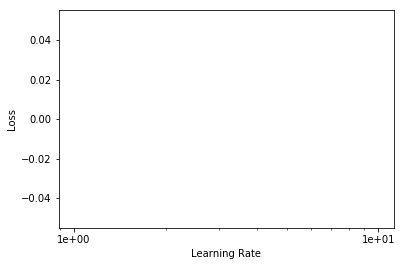

In [127]:
learn.recorder.plot()

In [130]:
learn.fit_one_cycle(10,max_lr=10)

epoch,train_loss,valid_loss,accuracy,time
0,1.990920,16460.886719,0.100121,00:11
1,9.057902,831.314453,0.843751,00:11
2,28.568087,0.479202,0.969103,00:11
3,14.049351,65.272690,0.030897,00:12
4,5.827307,0.956250,0.030897,00:11
5,4.748142,4.964274,0.030897,00:12
6,5.939546,28361.156250,0.481085,00:12
7,1.403221,28.825384,0.189879,00:12
8,0.552675,423.381195,0.910188,00:11
9,0.463849,24893088.000000,0.866333,00:11


In [137]:
h = pd.read_csv('exps/history.csv',index_col='epoch')

In [138]:
h.head(2)

,train_loss,valid_loss,accuracy,time
epoch,,,,
0,0.477226,0.377997,0.844145,NaN
1,0.473272,0.352482,0.880315,NaN


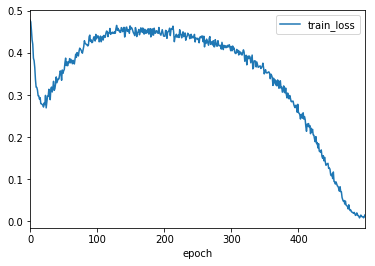

In [139]:
h.plot(y = 'train_loss')

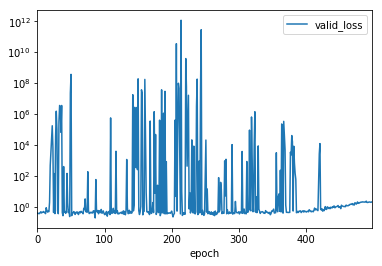

In [140]:
h.plot(y='valid_loss',logy=True)

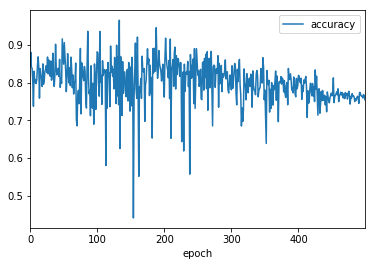

In [141]:
h.plot(y='accuracy')

In [1]:
#learn.model.load_state_dict(torch.load('exps/models/small_Resnet_with_more_reg'))

In [145]:
learn.recorder.plot_losses()

AttributeError: 'Learner' object has no attribute 'recorder'

In [71]:
p = learn.get_preds(DatasetType.Valid)

In [72]:
act = trn_df.target.loc[val_rows]

In [75]:
len(act),len(p[1])

(165000, 165000)

In [81]:
preds = p[0].cpu().numpy()

In [84]:
preds_am = preds.argmax(axis=1)

In [85]:
len(preds_am)

165000

In [86]:
ans = (preds_am == act)

In [87]:
ans.mean()

0.7875090909090909

In [88]:
from sklearn.metrics import roc_auc_score,scorer

In [89]:
roc_auc_score(act,preds_am)

0.7371166945972532

In [90]:
p_v = learn.get_preds(DatasetType.Test)

In [92]:
val_preds = p_v[0].cpu().numpy()

In [95]:
sub = val_preds.argmax(axis=1)

In [96]:
ss = pd.read_csv('sample_submission.csv',index_col='ID_code')

In [97]:
ss.head(2)

,target
ID_code,
test_0,0
test_1,0


In [99]:
len(sub),len(ss)

(200000, 200000)

In [100]:
ss.target = sub

In [101]:
ss.to_csv('nn_2000ep.csv')

In [102]:
_ = pd.read_csv('nn_2000ep.csv',index_col='ID_code')

In [103]:
_.head(2)

,target
ID_code,
test_0,1
test_1,1


In [104]:
!kaggle c submit santander-customer-transaction-prediction -f nn_2000ep.csv -m "2000ep nn"

100%|███████████████████████████████████████| 2.56M/2.56M [00:09<00:00, 293kB/s]
Successfully submitted to Santander Customer Transaction Prediction